# 1. Intro

***Goal: Forecast the default rate for the next 12 months***

In this notebook, we are going to:

1. Explore the data: check seasonality, trend and residuals of the time series.
2. Create an ARIMA forecasting model for the defaul rate with different hyperparameters.
3. Choose a ARIMA model by picking the one with the lowest AIC (Akaike information criteria)
4. Forecast the default rate for the next 12 months.

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

from statsmodels.tsa.arima.model import ARIMA


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

file_path = 'dados.csv'

# 1. Data exploration

In [7]:
# Read the CSV file with the correct delimiter
df = pd.read_csv(file_path, delimiter=';', decimal=',')

# Convert 'data' to datetime format
df['data'] = pd.to_datetime(df['data'], format='%d/%m/%Y')

In [10]:
# Initial date
df.head(1)

,data,valor
0,2011-03-01,3.17


In [12]:
# Final date
df.tail(1)

,data,valor
148,2023-07-01,3.6


In [3]:
# Calculating summary statistics for the "Default Rate" column
summary_stats = df['valor'].describe()
summary_stats

count    149.000000
mean       3.143087
std        0.453813
min        2.120000
25%        2.890000
50%        3.120000
75%        3.540000
max        4.040000
Name: valor, dtype: float64

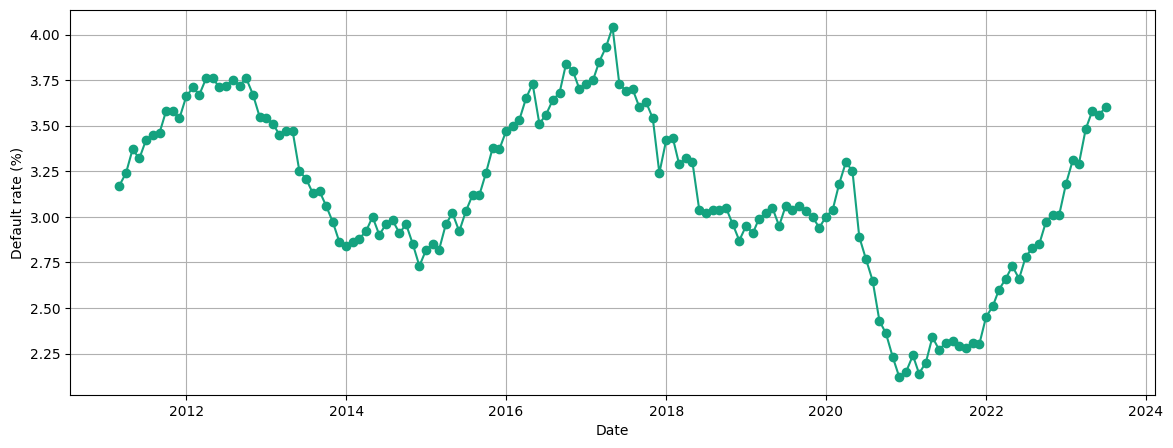

In [6]:
# Plotting the data
plt.figure(figsize=(14, 5))
plt.plot(df['data'], df['valor'], marker='o', linestyle='-', color="#14a27f")
plt.xlabel('Date')
plt.ylabel('Default rate (%)')
plt.grid(True)
plt.show()

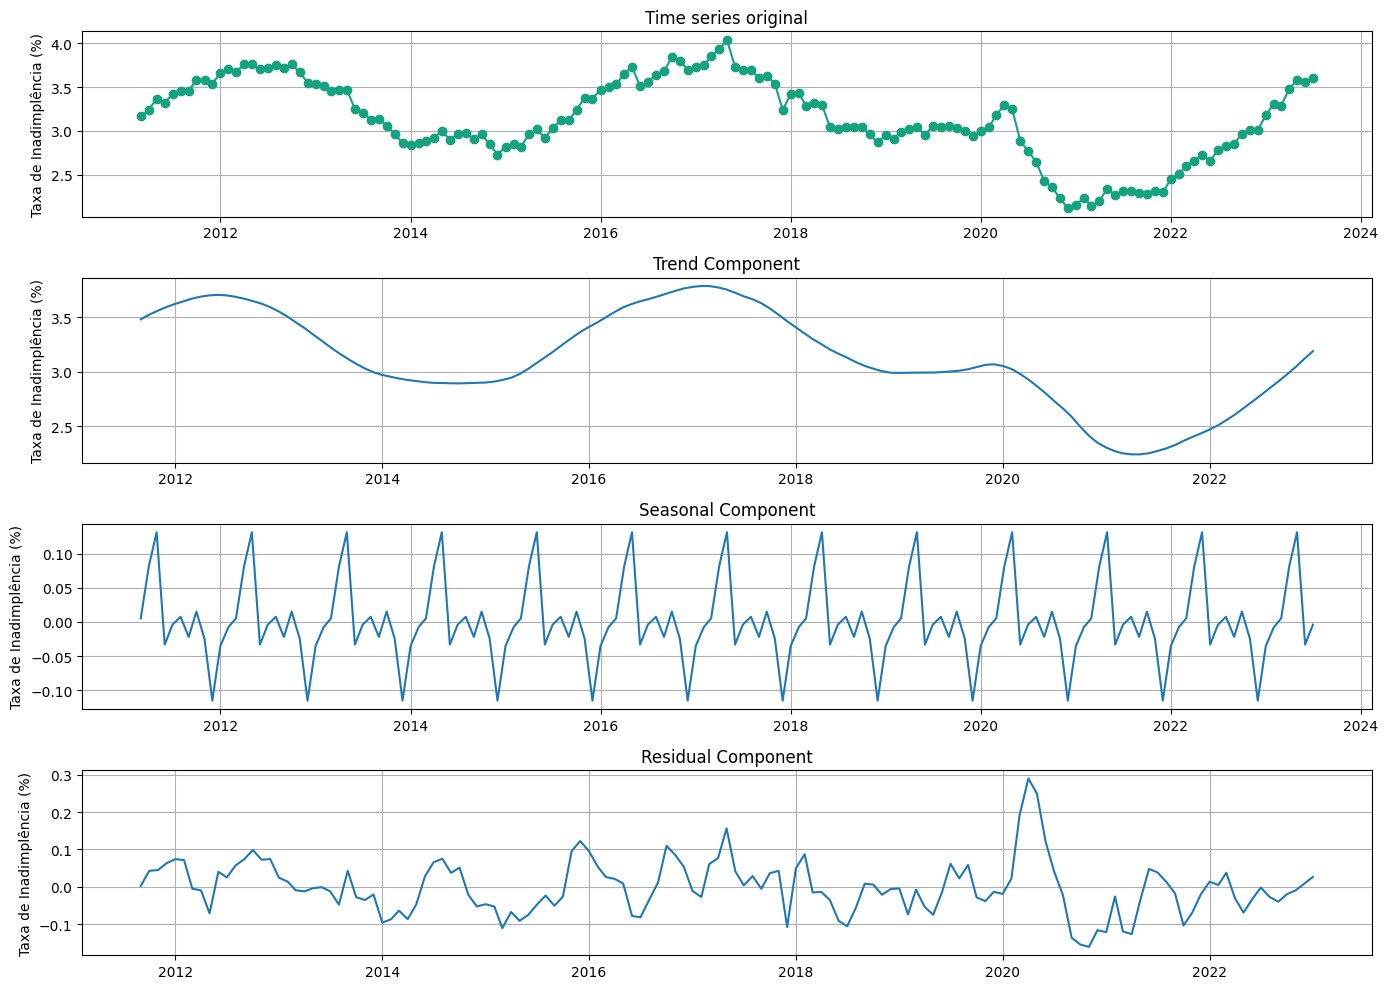

In [15]:
# Conduct Seasonal Decomposition of Time Series (STL)
# We will assume an yearly period for the series
decomposition = seasonal_decompose(df.set_index('data')['valor'], period=12)

# Plot the original time series, trend, seasonal, and residual components
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(decomposition.observed, marker='o', linestyle='-', color="#14a27f")
plt.title('Time series original')
plt.ylabel('Taxa de Inadimplência (%)')
plt.grid(True)

plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Trend Component')
plt.ylabel('Taxa de Inadimplência (%)')
plt.grid(True)

plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('Seasonal Component')
plt.ylabel('Taxa de Inadimplência (%)')
plt.grid(True)


plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Residual Component')
plt.ylabel('Taxa de Inadimplência (%)')
plt.grid(True)

plt.tight_layout()
plt.show()


- Trend Component: This part captures the underlying trend in the data. From the plot, it appears that there is a slight upward trend, particularly in recent years.

- Seasonal Component: This captures the seasonal variations in the data. It seems that the seasonal effect is only minor, being responsible by +/- 0.1% at most.

- Residual Component: These are the residuals or the noise after removing the trend and seasonal components from the original time series.

# 2. Modeling with ARIMA

Let's check if we can consider the time series stationary, so we can use $d=0$

In [16]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(df['valor'])

# Extract the p-value
p_value = adf_result[1]
p_value

0.005933300143819119

The p-value is less than 0.05, which means we can reject the null hypothesis at the 95% confidence level. This indicates that the data is stationary and then $d=0$.

In [17]:
# Separate the time series data into training and test sets
train_size = int(len(df) * 0.9)

train, test = df.iloc[:train_size], df.iloc[train_size:]

# Verify the length of each dataset
len(train), len(test)


(134, 15)

In [86]:
test

,data,valor
134,2022-05-01,2.73
135,2022-06-01,2.66
136,2022-07-01,2.78
137,2022-08-01,2.83
138,2022-09-01,2.85
139,2022-10-01,2.97
140,2022-11-01,3.01
141,2022-12-01,3.01
142,2023-01-01,3.18
143,2023-02-01,3.31


In [18]:
# Function to fit and evaluate an ARIMA model
def evaluate_arima_model(train, arima_order):
    # Fit the ARIMA model
    model = ARIMA(train, order=arima_order)
    model_fit = model.fit()
    
    # Calculate the Akaike information criterion
    aic = model_fit.aic
    return aic

# Function to perform grid search for ARIMA hyperparameters
def evaluate_models(train, p_values, d_values, q_values):
    best_aic, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    aic = evaluate_arima_model(train, order)
                    if aic < best_aic:
                        best_aic, best_cfg = aic, order
                except:
                    continue
    return best_aic, best_cfg

# Define the p, d, and q values to try
p_values = range(0,13)
d_values = [0]
q_values = range(0,13)

# Perform grid search
best_score, best_order = evaluate_models(train['valor'], p_values, d_values, q_values)

/Users/elton.ogoshi/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/elton.ogoshi/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/elton.ogoshi/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/elton.ogoshi/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters foun

In [19]:
best_score, best_order

(-284.14849314903256, (7, 0, 7))

In [20]:
# Fit the ARIMA model with the best hyperparameters
best_arima_model = ARIMA(train['valor'], order=best_order)
best_arima_fit = best_arima_model.fit()

# Forecast the test set
forecast = best_arima_fit.get_forecast(steps=len(test))
forecast_test = forecast.predicted_mean
conf_int_test = forecast.conf_int()

/Users/elton.ogoshi/miniconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


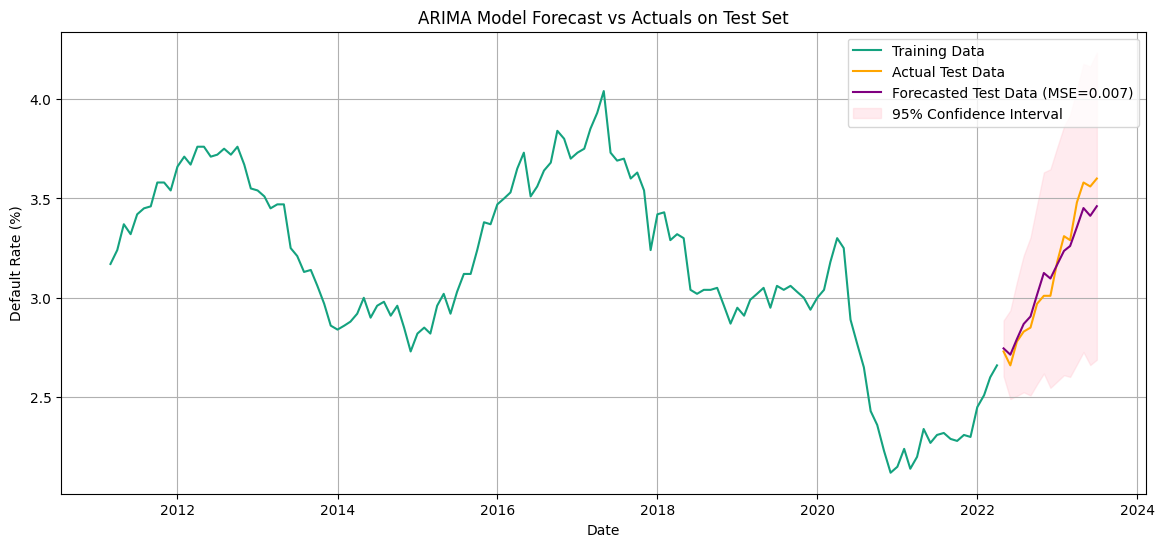

In [25]:
# Calculate the Mean Squared Error (MSE) for the test set
test_mse = mean_squared_error(test['valor'], forecast_test)

# Plot the actual vs forecasted values for the test set
plt.figure(figsize=(14, 6))
plt.plot(train['data'], train['valor'], label='Training Data', color='#14a27f')
plt.plot(test['data'], test['valor'], label='Actual Test Data', color='orange')
plt.plot(test['data'], forecast_test, label=f'Forecasted Test Data (MSE={test_mse:0.3f})', color='purple')
plt.fill_between(test['data'], conf_int_test.iloc[:, 0], conf_int_test.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('ARIMA Model Forecast vs Actuals on Test Set')
plt.xlabel('Date')
plt.ylabel('Default Rate (%)')
plt.legend()
plt.grid(True)
plt.show()


# 4. Result

## 4.1 Projection for the next 12 months

/Users/elton.ogoshi/miniconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


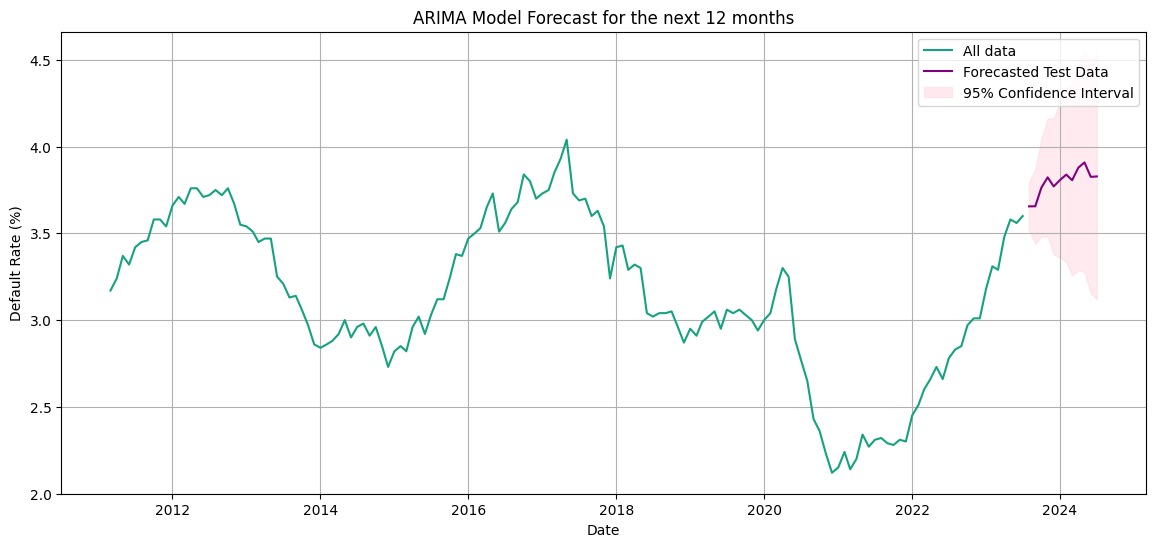

In [28]:
# Combine the train and validation sets for final model training
final_model_data = pd.concat([train, test])

# Fit the ARIMA model with the best hyperparameters
best_arima_model = ARIMA(final_model_data['valor'], order=best_order)
best_arima_fit = best_arima_model.fit()

# Generate dates for the next 12 months
n=12
next_12_months_dates = pd.date_range(final_model_data.set_index('data').index[-1] + pd.Timedelta(days=30), periods=n, freq='MS')

# Forecast the test set
forecast = best_arima_fit.get_forecast(steps=n)
forecast_next_12_months = forecast.predicted_mean
conf_int_next_12_months = forecast.conf_int()

# Plot the actual vs forecasted values for 12 months
plt.figure(figsize=(14, 6))
plt.plot(final_model_data['data'], final_model_data['valor'], label='All data', color='#14a27f')
plt.plot(next_12_months_dates, forecast_next_12_months, label='Forecasted Test Data', color='purple')
plt.fill_between(next_12_months_dates, conf_int_next_12_months.iloc[:, 0], conf_int_next_12_months.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('ARIMA Model Forecast for the next 12 months')
plt.xlabel('Date')
plt.ylabel('Default Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
forecast_next_12_months

149    3.655610
150    3.656063
151    3.763033
152    3.822940
153    3.770683
154    3.807411
155    3.838700
156    3.806348
157    3.879085
158    3.908973
159    3.825738
160    3.828167
Name: predicted_mean, dtype: float64

### Conclusion:

The forecasting shows a upward behaviour for the default rate, followed by a plato.

## 4.2 What are the main drivers for the default rate?

The main drivers for a default rate time series can vary depending on the specific economic context, but generally, they might include a combination of macroeconomic indicators, such as:
- Unemployment rate: Higher unemployment often correlates with higher default rates as people lose their income sources. 
- Inflation rate: High inflation can erode consumers' purchasing power, leading to defaults.
- ***SELIC index***:  A higher SELIC index rate can increase the cost of borrowing, leading to higher defaults.

As an exercise, let's visualize how ***SELIC index*** compares to the default rate.

In [80]:
# Read the CSV file with the correct delimiter
selic = pd.read_csv('selic.csv', delimiter=';', decimal=',')

# Convert 'data' to datetime format
selic['data'] = pd.to_datetime(selic['data'], format='%d/%m/%Y')
selic = selic[selic['data'] >= '2010-03-01']
selic.set_index('data', inplace=True)

In [83]:
# df.set_index('data', inplace=True)

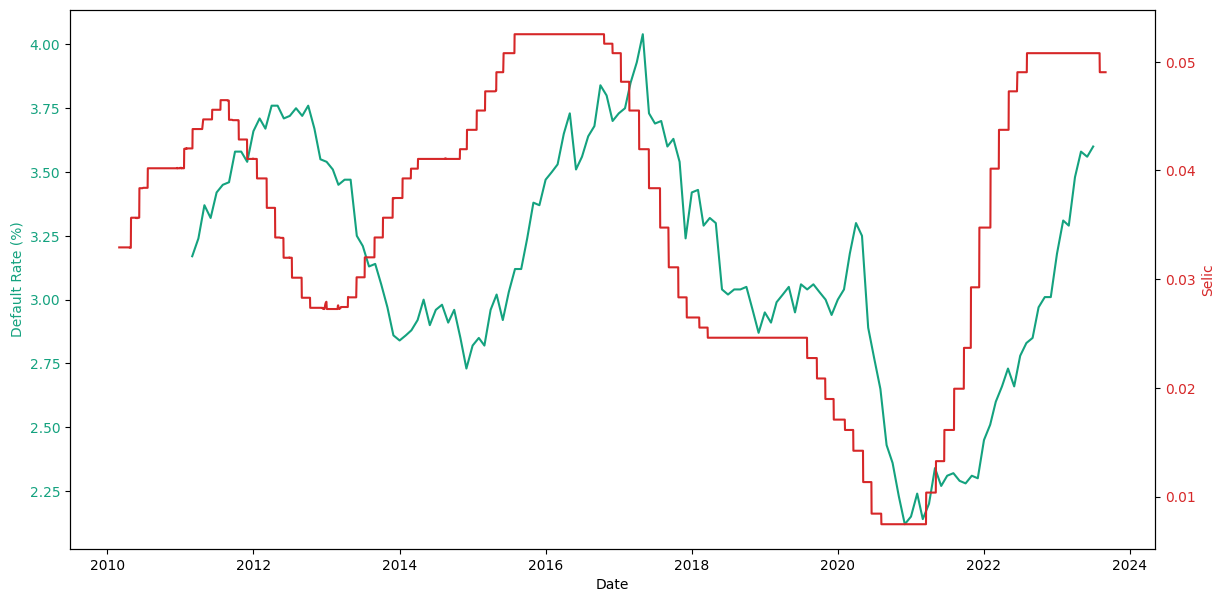

In [85]:
# Plot both time series
fig, ax1 = plt.subplots(figsize=(14, 7))

color = '#14a27f'
ax1.set_xlabel('Date')
ax1.set_ylabel('Default Rate (%)', color=color)
ax1.plot(df.index, df.valor, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Selic', color=color)
ax2.plot(selic.index, selic.valor, color=color)
ax2.tick_params(axis='y', labelcolor=color)

We can see that the default rate shows a lagged behaviour when compared to SELIC. This indicates a causality from SELIC to default rate.

In [93]:

# Prepare a DataFrame with both SELIC and default rate data for the period where both exist
# Forward fill the SELIC data to match the monthly frequency of the default rate data
combined_data = pd.DataFrame({
    'default_rate': df['valor'],
    'selic': selic.reindex(df.index, method='ffill')['valor']
}).dropna()  # Drop any rows with missing values

# Run the Granger Causality test
# The maxlag parameter specifies the maximum number of lags to be considered for the test
# A maxlag of 12 is chosen to consider up to a year of past data
test_result = grangercausalitytests(combined_data, maxlag=12, verbose=True)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=31.1712 , p=0.0000  , df_denom=145, df_num=1
ssr based chi2 test:   chi2=31.8162 , p=0.0000  , df=1
likelihood ratio test: chi2=28.8190 , p=0.0000  , df=1
parameter F test:         F=31.1712 , p=0.0000  , df_denom=145, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=13.5862 , p=0.0000  , df_denom=142, df_num=2
ssr based chi2 test:   chi2=28.1292 , p=0.0000  , df=2
likelihood ratio test: chi2=25.7385 , p=0.0000  , df=2
parameter F test:         F=13.5862 , p=0.0000  , df_denom=142, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.5782  , p=0.0000  , df_denom=139, df_num=3
ssr based chi2 test:   chi2=30.1816 , p=0.0000  , df=3
likelihood ratio test: chi2=27.4346 , p=0.0000  , df=3
parameter F test:         F=9.5782  , p=0.0000  , df_denom=139, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.5220  , p=0.0018  

/Users/elton.ogoshi/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


The Granger Causality test helps to determine whether one time series can predict another time series. In this case, we are testing if changes in the SELIC rate can predict changes in the default rate. Here are some key points from the test results:

- **Lag 1**: With just one lag, the Granger Causality test shows very strong evidence against the null hypothesis, with a p-value close to 0. This suggests that the SELIC rate with a one-month lag is predictive of the default rate.
  
- **Lag 2 and Lag 3**: Similar to Lag 1, these also show strong evidence against the null hypothesis, meaning SELIC rates at lags 2 and 3 also have predictive power for the default rate.
  
- **Lag 4 to Lag 6**: The p-values remain significant, although they are less strong than for lags 1 to 3.
  
- **Lag 7 to Lag 12**: The p-values are still generally below the 0.05 threshold (except for Lag 10, Lag 11, and Lag 12), indicating that these lags also have some predictive power, but the evidence is weaker compared to earlier lags.

In summary, the Granger Causality test suggests that the SELIC rate has predictive power for the default rate, especially at shorter lags (1 to 3 months). This indicates a likely causal relationship, where changes in the SELIC rate precede changes in the default rate.

### Conclusion: 

As SELIC in the last plot shows an upward trend and then a plato followed by a slight decrease, we can expect the same behavior for the default rate, validating the results of the ARIMA forecasting (using only the default rate itself) for the next 12 months.